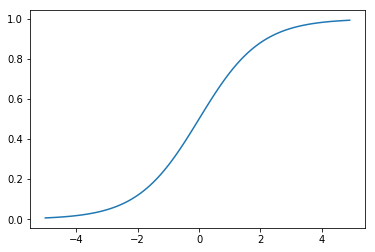

In [3]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

def logistic(z):
    return 1. / (1. + nd.exp(-z))

x = nd.arange(-5, 5, .1)
y = logistic(x)

plt.plot(x.asnumpy(),y.asnumpy())
plt.show()

In [8]:

data_ctx = mx.cpu()
# Change this to `mx.gpu(0) if you would like to train on an NVIDIA GPU
model_ctx = mx.cpu()

with open("a1atrain.txt") as f:
    train_raw = f.read()

with open("a1atest.txt") as f:
    test_raw = f.read()

In [9]:
def process_data(raw_data):
    train_lines = raw_data.splitlines()
    num_examples = len(train_lines)
    num_features = 123
    X = nd.zeros((num_examples, num_features), ctx=data_ctx)
    Y = nd.zeros((num_examples, 1), ctx=data_ctx)
    for i, line in enumerate(train_lines):
        tokens = line.split()
        label = (int(tokens[0]) + 1) / 2  # Change label from {-1,1} to {0,1}
        Y[i] = label
        for token in tokens[1:]:
            index = int(token[:-2]) - 1
            X[i, index] = 1
    return X, Y

In [10]:
Xtrain, Ytrain = process_data(train_raw)
Xtest, Ytest = process_data(test_raw)

In [11]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(1605, 123)
(1605, 1)
(30956, 123)
(30956, 1)


In [12]:
print(nd.sum(Ytrain)/len(Ytrain))
print(nd.sum(Ytest)/len(Ytest))


[0.24610592]
<NDArray 1 @cpu(0)>

[0.24053495]
<NDArray 1 @cpu(0)>


In [13]:
batch_size = 64

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtrain, Ytrain),
                                      batch_size=batch_size, shuffle=True)

test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtest, Ytest),
                                      batch_size=batch_size, shuffle=True)

In [14]:
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

In [15]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})


In [16]:
def log_loss(output, y):
    yhat = logistic(output)
    return  - nd.nansum(  y * nd.log(yhat) + (1-y) * nd.log(1-yhat))

In [17]:
epochs = 30
loss_sequence = []
num_examples = len(Xtrain)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = log_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss ))
    loss_sequence.append(cumulative_loss)

Epoch 0, loss: 2091.8096163272858
Epoch 1, loss: 1983.1064975261688
Epoch 2, loss: 1886.821885585785
Epoch 3, loss: 1802.5302715301514
Epoch 4, loss: 1729.8911657333374
Epoch 5, loss: 1668.039888381958
Epoch 6, loss: 1615.7548598647118
Epoch 7, loss: 1571.1981191635132
Epoch 8, loss: 1533.6484870910645
Epoch 9, loss: 1501.8312501907349
Epoch 10, loss: 1474.3323120474815
Epoch 11, loss: 1450.4569683074951
Epoch 12, loss: 1429.6504392623901
Epoch 13, loss: 1410.5726482868195
Epoch 14, loss: 1393.4118461608887
Epoch 15, loss: 1377.515421628952
Epoch 16, loss: 1362.95581305027
Epoch 17, loss: 1349.1225657463074
Epoch 18, loss: 1336.1075270175934
Epoch 19, loss: 1323.623859256506
Epoch 20, loss: 1311.8782153129578
Epoch 21, loss: 1300.3182944059372
Epoch 22, loss: 1289.3274611234665
Epoch 23, loss: 1278.662878036499
Epoch 24, loss: 1268.5139541625977
Epoch 25, loss: 1258.5402975082397
Epoch 26, loss: 1248.8959431648254
Epoch 27, loss: 1239.484607219696
Epoch 28, loss: 1230.294638633728
Epoc

Text(0, 0.5, 'average loss')

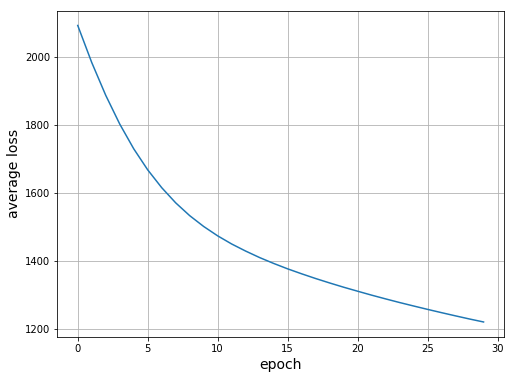

In [18]:
# plot the convergence of the estimated loss function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [19]:
num_correct = 0.0
num_total = len(Xtest)
for i, (data, label) in enumerate(test_data):
    data = data.as_in_context(model_ctx)
    label = label.as_in_context(model_ctx)
    output = net(data)
    prediction = (nd.sign(output) + 1) / 2
    num_correct += nd.sum(prediction == label)
print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

Accuracy: 0.735 (22766.0/30956)
